In [1]:
import os
os.environ['https_proxy'] = '127.0.0.1:17890'
os.environ['http_proxy'] = '127.0.0.1:17890'
import torch
from PIL import Image, ImageDraw
from transformers import CLIPProcessor, CLIPModel
from torch.nn.functional import cosine_similarity
from utils import Html2BboxTree

device = 'cuda:6'

path = '/data02/users/lz/code/UICoder/outputs/stage1'
model_path = '/data02/models/clip-vit-large-patch14'

border_color = '#000'
border_width = 1

/data02/users/lz/miniconda3/envs/UICoder/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = CLIPModel.from_pretrained(model_path).to(device)
processor = CLIPProcessor.from_pretrained(model_path)

In [3]:
def string_to_color(word):
    # 使用字符串哈希函数计算字符串的哈希值
    hash_val = hash(word)
    
    # 将哈希值映射到RGB颜色空间的范围内
    r = (hash_val & 0xFF0000) >> 16
    g = (hash_val & 0x00FF00) >> 8
    b = hash_val & 0x0000FF
    
    # 格式化为十六进制颜色代码
    color_code = "#{:02X}{:02X}{:02X}".format(r, g, b)
    
    return color_code

def make_layout_image(tree, draw=None):
    bbox = tree['bbox']
    color = string_to_color(tree['type'])

    if not draw:
        image = Image.new('RGB',(bbox[2],bbox[3]),color)
        draw = ImageDraw.Draw(image)
    else:
        image = None
        if bbox[2] > border_width*2 and bbox[3] > border_width*2:
            draw.rectangle([(bbox[0],bbox[1]), (bbox[0]+bbox[2],bbox[1]+bbox[3])], fill=border_color)
            draw.rectangle([(bbox[0]+border_width,bbox[1]+border_width), (bbox[0]+bbox[2]-border_width*2,bbox[1]+bbox[3]-border_width*2)], fill=color)

    for ctree in tree['children']:
        make_layout_image(ctree, draw)

    return image

def image2feature(image):
    inputs = processor(text=None, images=image, return_tensors="pt", padding=True)
    inputs = {key: val.to(model.device) for key, val in inputs.items()}
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)

    return image_features[0].detach().cpu()

In [4]:
index = 30

In [5]:

for pair_name in sorted(os.listdir(path), key=lambda x: int(x))[index:]:
    pair_path = os.path.join(path,pair_name)
    with open(os.path.join(pair_path,'answer.html')) as f:
        answer_html = f.read()
    with open(os.path.join(pair_path,'prediction.html')) as f:
        prediction_html = f.read()
    break

index += 1

In [6]:
tree_ans = Html2BboxTree(answer_html)
image_ans = make_layout_image(tree_ans)

tree_pred = Html2BboxTree(prediction_html)
image_pred = make_layout_image(tree_pred)

In [7]:
width1, height1 = image_ans.size
width2, height2 = image_pred.size

new_width = width1 + width2 + 10
max_height = max(height1, height2)
new_image = Image.new("RGB", (new_width, max_height))

new_image.paste(image_ans, (0, 0))
new_image.paste(image_pred, (width1+10, 0))

In [8]:
ia_feature = image2feature(image_ans)
ip_feature = image2feature(image_pred)

cosine_similarity(ia_feature,ip_feature,dim=-1).item()

0.9999998211860657

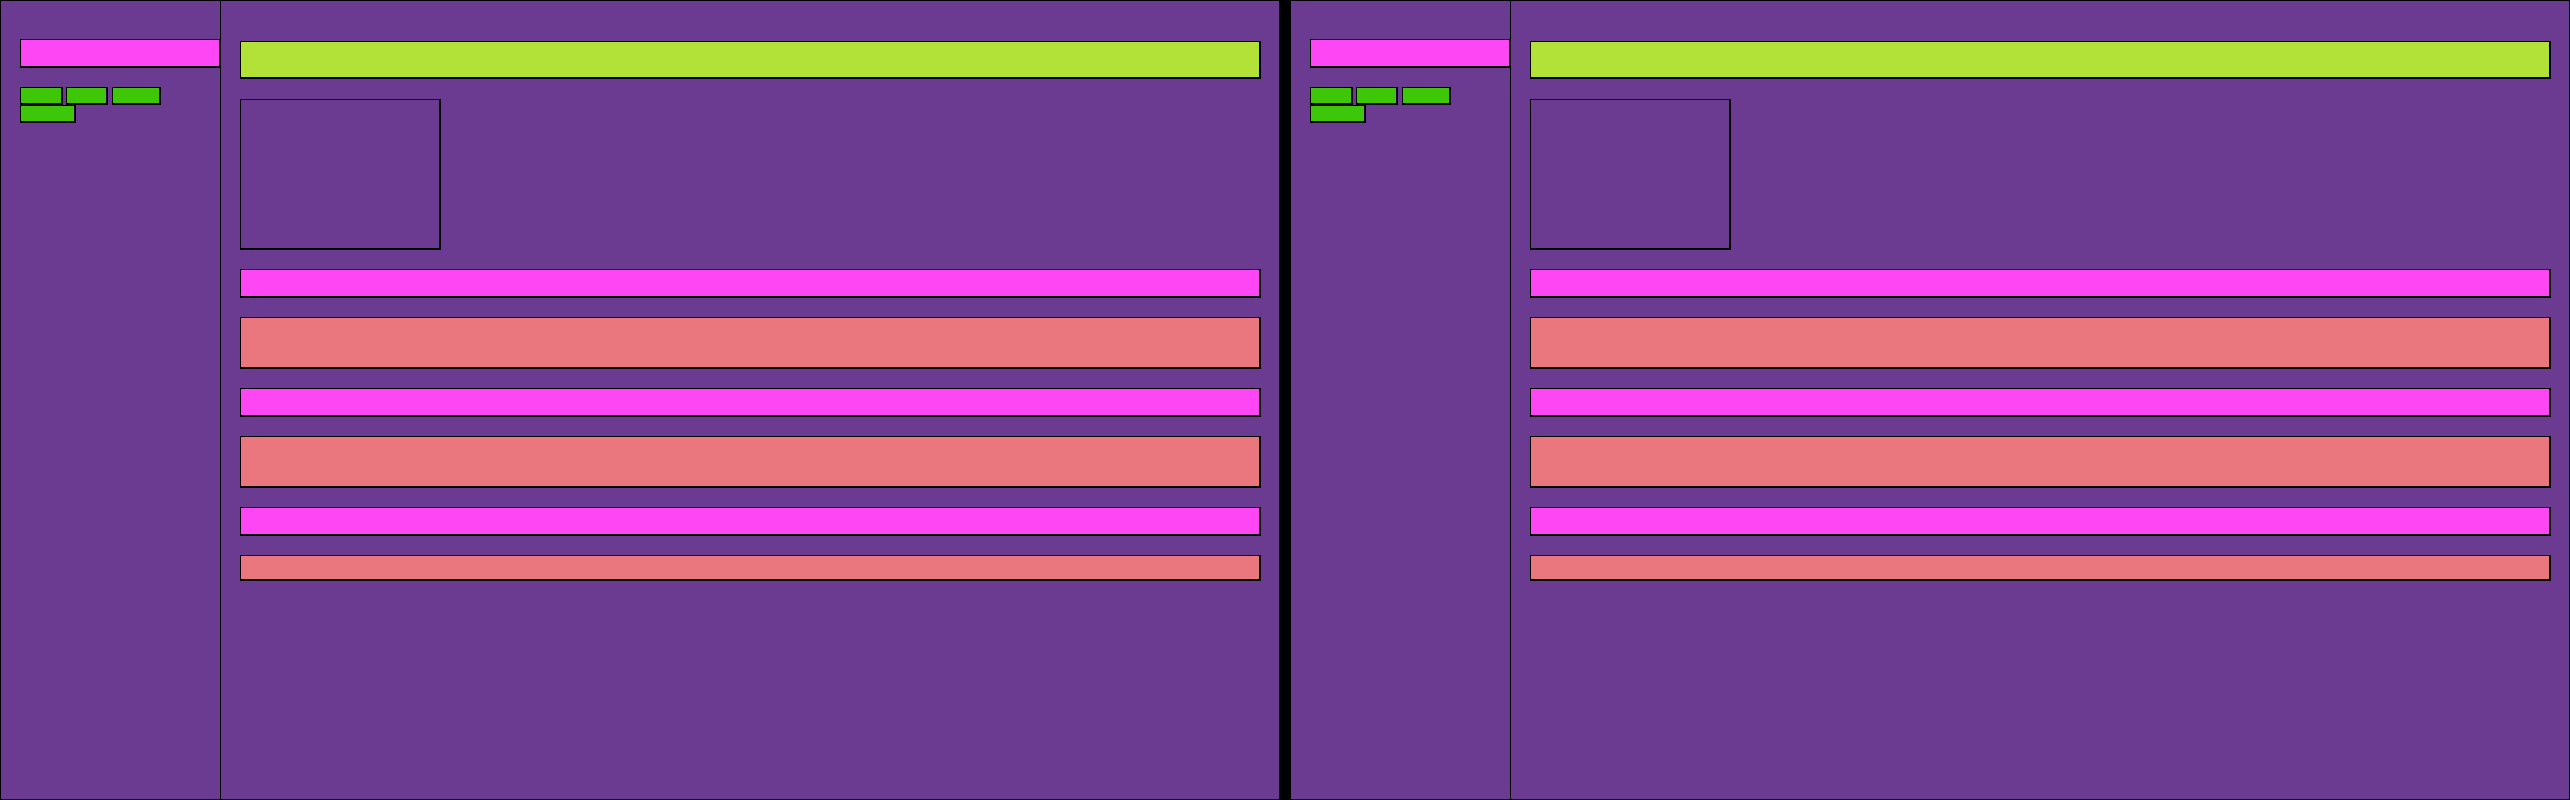

In [9]:
new_image